# Задание 1.2. Свёрточные сети. Pytorch. [Кросспроверка. 8 баллов]

## DL курс на ВМК. Осень 2024

Дата выдачи: <span style="color:red">__20 сентября 21:00__</span>.

Мягкий дедлайн: <span style="color:red">__06 октября 22:00__</span>.

Стоимость: __8 баллов__.

<span style="color:red">__В ноутбуке все клетки должны выполняться без ошибок при последовательном их выполнении.__</span>

Перед началом выполнения переведите ноутбук в `Доверенный режим` (`Trusted`) для корректного отображения изображений:

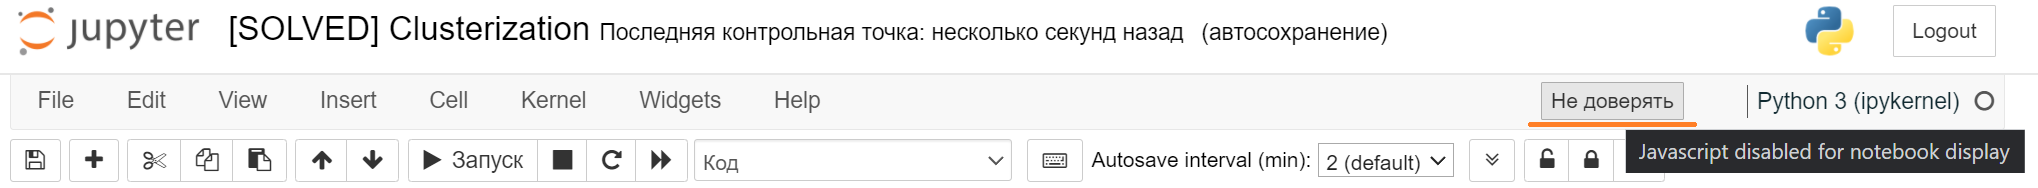

In [10]:
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
import numpy as np

import torch

В предыдущем задании мы тренировались в использовании фреймворка Pytorch, написании собственных модулей, реализации цикла обучения на игрушечном датасете с малым числом объектов довольно низкого разрешения. Сейчас же мы пойдём с другой стороны — будем использовать готовые реализации слоёв для нейронной сети и будем тестировать модели на данных умеренно большого размера и разрешения.

Так же как и в прошлом задании мы будем решать задачу многоклассовой классификации. При этом, вместо полносвязных сетей мы будем конструировать свёрточную сеть, которая за счёт своего inductive bias обычно работает лучше в задачах computer vision (CV).

В этот раз начнём с загрузки и предобработки данных для обучения. Pytorch реализует готовый набор классов и функций для работы с наборами данных. Обычно, при работе с **Pytorch** датасет представляют в виде наследника класса `torch.utils.data.Dataset`:
```python
class DatasetExample(torch.utils.data.Dataset):
    def __init__(self):
        super().__init__()
        
    def __getitem__(self, idx):
        '''
        Возвращает элемент датасета по его индексу
        :param int idx: Номер элемента в датасете
        :returns: Объект из выборки с порядковым номером idx
        '''
        ...
        
    def __len__(self):
        '''
        Опциональный метод, возвращает число элементов в датасете
        '''
        ...
```

Базовая работа с изображениями в **Pytorch** выделена в отдельный модуль `torchvision`. Эта библиотека позволяет:
* Загружать и работать с популярными датасетами компьютерного зрения
* Применять преобразования к изображениям в `PIL`, `numpy.ndarray` и `torch.Tensor` форматах
* Использовать специфичные для CV блоки и функции потерь
* Использовать готовые архитектуры CV моделей (включая предобученные модели)

Все датасеты в библиотеке `torchvision` наследуются от `torch.utils.data.Dataset`. Также, почти все датасеты имеют аргументы конструктора класса `transforms` и `target_transform`, которые определяют трансформации, применяемые ко входам сети (обычно к изображениям) и к таргетам (обычно к меткам классов) соответственно. Основные сценарии использования трансформаций включают в себя:
* Преобразование изображений из одного формата в другой. Например, обычно датасеты хранят и возвращают изображения в `PIL` формате, тогда как в нейросеть необходимо передавать изображения в виде `torch.Tensor`
* Нормализация и аугментация изображений
* Нормализация меток классов, то есть перевод их и строкового представления в численное

В библиотеке `torchvision` содержится большой набор [готовых трансформаций](https://pytorch.org/vision/stable/transforms.html).

Для работы с датасетом `CIFAR10` нам понадобится следующие из них:
* `torchvision.transforms.ToTensor` — преобразование `PIL` изображения в `torch.Tensor`
* `torchvision.transforms.Normalize` — нормализация изображения в формате `torch.Tensor`
* `torchvision.transforms.Compose` — класс, позволяющий объединять несколько последовательных трансформаций в одну

In [8]:
import torchvision

Загрузим датасет `CIFAR10` и посмотрим на его содержимое:

In [14]:
# Обратите внимание на аргументы функции:
#   train отвечает за то, какой сплит нужно использовать, то есть обучающую или тестовую выборку
#   download отвечает за загрузку датасета из интернета
ds_train_no_transform = torchvision.datasets.CIFAR10(
    root='./', train=True, transform=None, download=True
)

100%|██████████| 170498071/170498071 [00:04<00:00, 40451099.04it/s]


Extracting ./cifar-10-python.tar.gz to ./


Описание датасета:
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./
    Split: Train

Объект датасета — PIL изображение и метка: (<PIL.Image.Image image mode=RGB size=32x32 at 0x7B3529D8E7D0>, 6)



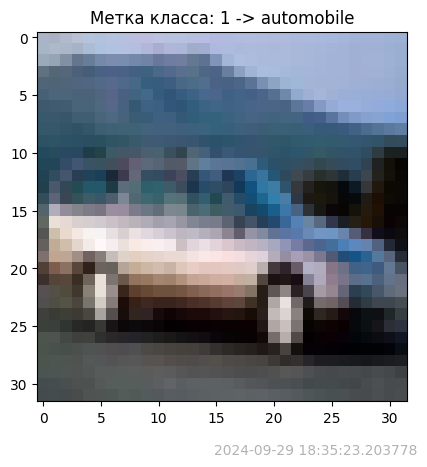

In [15]:
print(f'Описание датасета:\n{ds_train_no_transform}\n')
print(f'Объект датасета — PIL изображение и метка: {ds_train_no_transform[0]}\n')

image, label = ds_train_no_transform[4]

plt.imshow(image)

plt.gcf().text(
    0.5, 0.0, str(datetime.now()),
    fontsize=10, color='gray', alpha=0.6,
)

plt.title(f'Метка класса: {label} -> {ds_train_no_transform.classes[label]}')
plt.show()

Создадим `transform` для изображения, которое преобразует его из `PIL` формата в `torch.Tensor`, а затем нормализует:

In [16]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    # Используем среднее и стандартное отклонение, посчитанные для датасета CIFAR10
    # https://github.com/kuangliu/pytorch-cifar/issues/16
    torchvision.transforms.Normalize(
        mean=(0.4914, 0.4822, 0.4465),
        std=(0.2023, 0.1994, 0.2010)
    )
])

Применим трансформацию к изображению:

Тип изображения до трансформации: <class 'PIL.Image.Image'>. Размер: (32, 32). Тип изображения: RGB
Тип изображения после трансформации: <class 'torch.Tensor'>. Размер: torch.Size([3, 32, 32])


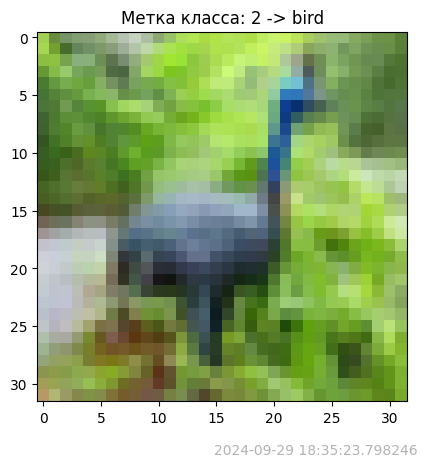

In [17]:
image, label = ds_train_no_transform[6]
print(f'Тип изображения до трансформации: {type(image)}. Размер: {image.size}. Тип изображения: {image.mode}')

image_tensor = transform(image)
print(f'Тип изображения после трансформации: {type(image_tensor)}. Размер: {image_tensor.shape}')

plt.imshow(image)

plt.gcf().text(
    0.5, 0.0, str(datetime.now()),
    fontsize=10, color='gray', alpha=0.6,
)

plt.title(f'Метка класса: {label} -> {ds_train_no_transform.classes[label]}')
plt.show()

Создайте датасеты с обучающим и тестовым сплитом датасета `CIFAR10`. Не забудьте передать функцию для трансформации.

In [ ]:
# ds_train_no_transform = torchvision.datasets.CIFAR10(
#     root='./', train=True, transform=None, download=True
# )

In [18]:
### your code here
ds_train = torchvision.datasets.CIFAR10(
    root='./', train=True, transform=transform, download=True
)
ds_test =  torchvision.datasets.CIFAR10(
    root='./', train=False, transform=transform, download=True
)

Files already downloaded and verified
Files already downloaded and verified


In [19]:
ds_train, ds_test

(Dataset CIFAR10
     Number of datapoints: 50000
     Root location: ./
     Split: Train
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
            ),
 Dataset CIFAR10
     Number of datapoints: 10000
     Root location: ./
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
            ))

Для удобства сразу же определим обратное преобразование, которое из тензора делает PIL изображение, которое можно корректно отобразить:

In [20]:
tmean, tstd = transform.transforms[1].mean, transform.transforms[1].std
tmean, tstd = np.array(tmean), np.array(tstd)

inverse_transform = transform = torchvision.transforms.Compose([
    torchvision.transforms.Normalize(
        mean=-tmean / tstd,
        std=1.0 / tstd
    ),
    torchvision.transforms.ToPILImage()
])

Посмотрим на несколько изображений из обучающей и тестовой выборок:

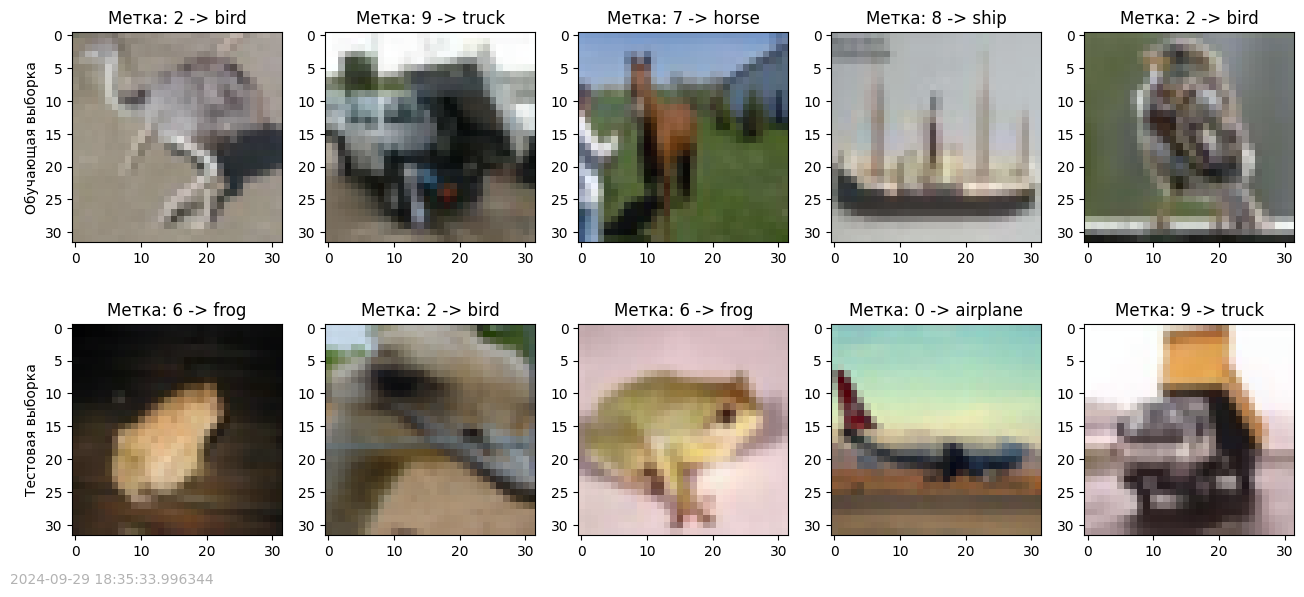

In [21]:
fig, axes = plt.subplots(2, 5, figsize=(13, 6))

for idx, ds in enumerate((ds_train, ds_test)):
    for jdx, kdx in enumerate(np.random.randint(0, len(ds), size=5)):
        image, label = ds[kdx]
        axes[idx, jdx].imshow(inverse_transform(image))
        axes[idx, jdx].set_title(f'Метка: {label} -> {ds.classes[label]}')

axes[0, 0].set_ylabel('Обучающая выборка')
axes[1, 0].set_ylabel('Тестовая выборка')

fig.text(
    0.0, 0.0, str(datetime.now()),
    fontsize=10, color='gray', alpha=0.6,
)

fig.tight_layout()
plt.show()

В прошлом задании мы использовали оптимизатор, который требовал подсчёта градиента по всей выборке. Однако, на практике обычно используют стохастические методы оптимизации, которые используют батчи объектов, семплированных из обучающей выборки. Хотя перемешивание и объединение в батчи объектов из датасета можно проводить вручную, **Pytorch** позволяет делать эти операции значительно более эффективно. Для этого обычно используют класс, который преобразует датасет в генератор батчей `torch.utils.data.DataLoader`. Данная обёртка позволяет объединять объекты в один батч, то есть объединять соответствующие тензоры в каждом объекте (например, изображения и соответствующие метки).

Основные параметры даталоадера:
- `batch_size` — размер подвыборки, семплируемый при каждом обращении к инстансту
- `shuffle` — перемешивать выборку или нет
- `num_workers` — ключевой параметр, который определяет производительность генератора батчей. Опишем влияние этого параметра подробнее. В процессе генерации очередного батча даталоадер должен выполнить несколько медленных процедур: запрос объектов из соответствующего датасета, что часто включает в себя чтение из жёсткого диска (так как большие датасеты не помещаются в оперативную память), применение трансформаций ко всем изображениям и конкатенация отдельных объектов в один тензор. Часто оказывается так, что вычисление прямого прохода по сети происходит быстрее, чем генерируется очередной батч, что приводит к существенно неэффективной программе. В таком случае, необходимо увеличить число параллельных процессов, каждый из которых генерирует очередной батч данных. На практике, выбор правильного числа воркеров может давать кратный прирост в скорости (обычно, перебор начинают с $3-4$ воркеров)

Создайте даталоадеры для обучающей и тестовой выборок CIFAR10. Учтите, что обучающая выборка должна перемешиваться при каждом проходе по выборке, а тестовая выборка — нет.

In [22]:
batch_size = 128

### your code here
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=batch_size, shuffle=True)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size=batch_size, shuffle=False)

Посмотрим на батч из даталоадера:

In [23]:
images, labels = next(iter(dl_train))
print(images.shape, labels.shape)

torch.Size([128, 3, 32, 32]) torch.Size([128])


Реализуем свёрточную VGG-подобную сеть. Сеть будет состоять из трёх основных блоков:
1. Свёрточный feature extractor
    * Эта последовательность слоёв принимает на вход изображение с $3$ каналами
    * Последовательность слоёв задаётся конфигурационным списком `cfg`:
        - Число означает количество выходных каналов очередной свёртки. Используйте свёртки с ядром $3\times3$ и паддингом $1$
        - `"M"` означает слой Max Pooling. Каждый такой слой должен уменьшать пространственные размерности картинки в $2$ раза
2. Слой Adaptive Average Pooling
    - Используйте выходное пространственное разрешение $2\times2$
3. Полносвязная "голова"-классификатор с $2$ скрытыми слоями размерности $128$

* В качестве функции активации везде используйте `ReLU`
* В зависимости от флага `use_batchnorm` добавьте батчнорм после каждого свёрточного слоя
* Между полносвязными слоям добавьте слои `Dropout` со значением $p = \text{dropout_p}$
* Используйте только готовые модули из `torch.nn`. Для объединения слоёв в блоки используйте `torch.nn.Sequential`

In [24]:
class ConvNet(torch.nn.Module):
    cfg = [32, "M", 64, 64, "M", 128, 128, "M"]

    def __init__(self, n_classes=10, use_batchnorm=False, dropout_p=0.0):
        '''
        :param int n_classes: Число выходных признаков
        :param bool use_batchnorm: Использовать ли батчнорм между свёрточными слоями
        :param float dropout_p: Вероятность обнуления активации слоем Dropout
        '''
        super().__init__()

        self.n_classes = n_classes

        ### your code here
        # self.features = ...
        # self.avgpool = ...
        # self.classifier = ...

        layers = []
        channels=3
        for i in self.cfg:
            if isinstance(i, int):
              layers.append(torch.nn.Conv2d(in_channels=channels, out_channels=i, kernel_size=3, padding=1))
              if (use_batchnorm): layers.append(torch.nn.BatchNorm2d(i))
              layers.append(torch.nn.ReLU(inplace=True))

              channels = i
            else:   #if i == 'M'
              layers.append(torch.nn.MaxPool2d(kernel_size=2, stride=2))


        #layer 1
        self.features = torch.nn.Sequential(*layers)
        #layer 2
        self.avgpool = torch.nn.AdaptiveAvgPool2d(output_size=(2, 2))
        # голова
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(128*2*2, 128),
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(p=dropout_p),
            torch.nn.Linear(128, 128),
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(p=dropout_p),
            torch.nn.Linear(128, n_classes)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x =x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


Проверьте, что ваша реализация сети проходит минимальные тесты:

In [25]:
assert sum(buffer.numel() for buffer in ConvNet(use_batchnorm=True).buffers()) == 837
assert sum(param.numel() for param in ConvNet(use_batchnorm=True).parameters()) == 362058
assert sum(param.numel() for param in ConvNet(use_batchnorm=False).parameters()) == 361226

sample_image = torch.randn([11, 3, 32, 32])
sample_model = ConvNet(use_batchnorm=False, dropout_p=0.5)
assert torch.all(torch.ne(sample_model.train()(sample_image), sample_model.eval()(sample_image)))

assert list(ConvNet().features(sample_image).shape) == [11, 128, 4, 4]
assert list(ConvNet().avgpool(ConvNet().features(sample_image)).shape) == [11, 128, 2, 2]
assert list(ConvNet()(sample_image).shape) == [11, 10]

В качестве функции потерь будем использовать, так же как и в прошлом задании, кроссэнтропию, но в этот раз её готовую реализацию. В качестве оптимизатора возьмём базовый оптимизатор в машинном обучении — SGD:

In [26]:
conv_network = ConvNet()

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(conv_network.parameters(), lr=2e-2)

Определим устройство для вычислений и перенесём модель:

In [27]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda', 0)

print(type(device), device)

<class 'torch.device'> cpu


In [28]:
conv_network.to(device)

ConvNet(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(2, 2))
  (classifier): Sequential(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0

Теперь осталось реализовать цикл обучения для нейронной сети. Так как в данном задании будет использоваться оптимизатор SGD, то необходимость в реализации шага оптимизации через функцию-замыкание отсутствует. Реализуйте шаг оптимизации любым удобным способом.

In [7]:
import tqdm.notebook as tqdm
from functools import partial

In [29]:
def training_loop(n_epochs, network, loss_fn, optimizer, dl_train, dl_test, device):
    '''
    :param int n_epochs: Число итераций оптимизации
    :param torch.nn.Module network: Нейронная сеть
    :param Callable loss_fn: Функция потерь
    :param torch.nn.Optimizer optimizer: Оптимизатор
    :param torch.utils.data.DataLoader dl_train: Даталоадер для обучающей выборки
    :param torch.utils.data.DataLoader dl_test: Даталоадер для тестовой выборки
    :param torch.Device device: Устройство на котором будут происходить вычисления
    :returns: Списки значений функции потерь и точности на обучающей и тестовой выборках после каждой итерации
    '''
    train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []
    for epoch in (pbar := tqdm.tqdm(range(n_epochs), total=n_epochs, leave=False)):
        # Переводим сеть в режим обучения
        ### your code here
        network.train()

        # Итерация обучения сети
        for images, labels in tqdm.tqdm(dl_train, total=len(dl_train), leave=False):
            # Реализуйте шаг оптимизации. Использовать функцию-замыкание для передачи в оптимизатор не обязательно
            # Можете вынести подсчёт градиентов из функции в сам цикл
            images = images.to(device)
            labels = labels.to(device)

            def closure(images, labels):
                '''
                Функция-замыкания для подсчёта градиентов функции потерь по обучающей выборке:
                    1. Отчистка текущих градиентов
                    2. Выполнение прямого прохода по сети в вычисление функции потерь
                    3. Вычисление градиентов функции потерь

                Для передачи аргументов в функцию-замыкание можно использовать функцию partial
                :returns: Значение функции потерь
                '''
                ### your code here
                optimizer.zero_grad()

                tmp = network(images)
                loss = loss_fn(tmp, labels)
                # train_losses.append(loss.item())

                return loss.backward()
                # return loss.item()

            # Шаг оптимизации
            ### your code here
            # optimizer.step(closure = closure)
            optimizer.step(closure=partial(closure, images=images, labels=labels))

        # Оцениваем качество модели каждые 3 итерации
        if epoch % 3 == 0 or epoch == n_epochs - 1:
            # Переводим сеть в инференс режим
            ### your code here
            network.eval()

            # При тестировании сети нет необходимости считать градиенты, поэтому можно отключить автоматическое дифференцирование
            #   для ускорения операций
            with torch.no_grad():
                # Вычисление качества и функции потерь на обучающей выборке
                ### your code here
                total, correct, train_loss_total = 0,0,0
                for images, labels in dl_train:
                    images = images.to(device)
                    labels = labels.to(device)

                    tmp = network(images)
                    pred = tmp.data.argmax(axis=1)

                    total += labels.size(0)
                    correct += (pred == labels).sum().item()
                    train_loss_total += loss_fn(tmp, labels)

                train_losses.append(train_loss_total/total)
                train_accuracies.append(correct/total * 100)

                # Вычисление качества и функции потерь на тестовой выборке
                ### your code here
                total, correct, test_loss_total = 0,0,0
                for images, labels in dl_test:
                    images = images.to(device)
                    labels = labels.to(device)

                    tmp = network(images)
                    pred = tmp.data.argmax(axis=1)

                    total += labels.size(0)
                    correct += (pred == labels).sum().item()
                    test_loss_total += loss_fn(tmp, labels)

                test_losses.append(test_loss_total/total)
                test_accuracies.append(correct/total * 100)


            pbar.set_description(
                'Loss (Train/Test): {0:.3f}/{1:.3f}. Accuracy, % (Train/Test): {2:.2f}/{3:.2f}\n'.format(
                    train_losses[-1], test_losses[-1], train_accuracies[-1], test_accuracies[-1]
                )
            )

    return train_losses, test_losses, train_accuracies, test_accuracies

Наконец, всё готово к обучению модели:

In [ ]:
n_epochs = 100
train_losses2, test_losses2, train_accs2, test_accs2 = training_loop(
    n_epochs=n_epochs, network=conv_network, loss_fn=loss_fn,
    optimizer=optimizer, dl_train=dl_train, dl_test=dl_test, device=device
)

In [ ]:
print(train_accs)
print(test_accs)

[10.0, 21.55, 38.379999999999995, 46.708, 52.212, 57.992, 64.748, 68.34, 73.402, 75.59, 77.794, 80.526, 85.69600000000001, 87.698, 87.22, 78.522, 93.53200000000001, 93.908, 96.66799999999999, 93.312, 97.60799999999999, 99.57000000000001, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]
[10.0, 21.73, 38.769999999999996, 46.96, 51.870000000000005, 57.19, 62.64999999999999, 65.64999999999999, 69.21000000000001, 69.78, 71.24000000000001, 72.66, 75.1, 74.76, 73.71, 67.31, 74.86, 74.38, 74.9, 73.41, 74.25, 75.44, 76.57000000000001, 76.62, 76.75, 76.68, 76.63, 76.57000000000001, 76.58, 76.51, 76.5, 76.47, 76.41, 76.39]


In [1]:
train_accs1 = [10.0, 21.55, 38.379999999999995, 46.708, 52.212, 57.992, 64.748, 68.34, 73.402, 75.59, 77.794, 80.526, 85.69600000000001, 87.698, 87.22, 78.522, 93.53200000000001, 93.908, 96.66799999999999, 93.312, 97.60799999999999, 99.57000000000001, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]
test_accs1 = [10.0, 21.73, 38.769999999999996, 46.96, 51.870000000000005, 57.19, 62.64999999999999, 65.64999999999999, 69.21000000000001, 69.78, 71.24000000000001, 72.66, 75.1, 74.76, 73.71, 67.31, 74.86, 74.38, 74.9, 73.41, 74.25, 75.44, 76.57000000000001, 76.62, 76.75, 76.68, 76.63, 76.57000000000001, 76.58, 76.51, 76.5, 76.47, 76.41, 76.39]


**Задание 1.** Посторим график качества на обучении и на тесте:

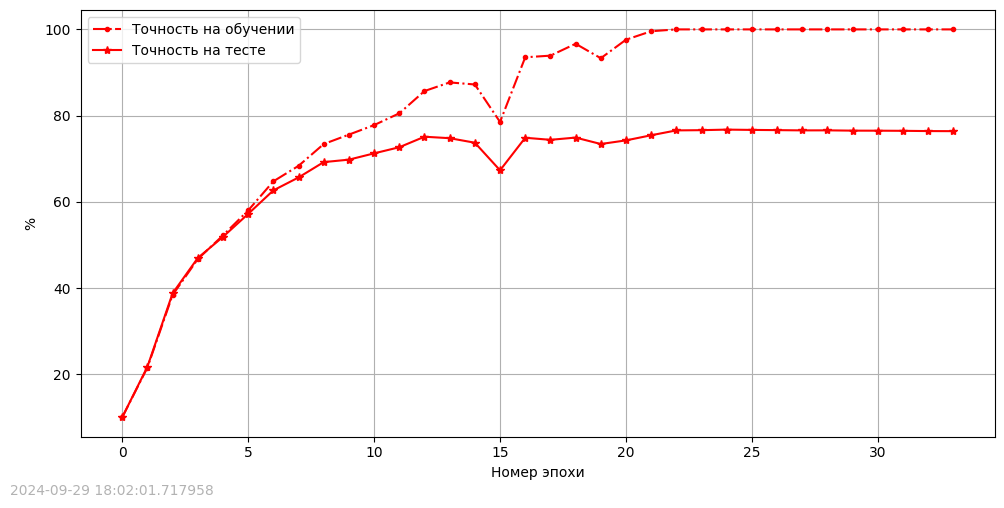

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(train_accs1, label="Точность на обучении", color='red', marker='.', linestyle='-.')
ax.plot(test_accs1, label="Точность на тесте", color='red', marker='*')

ax.set_xlabel("Номер эпохи")
ax.set_ylabel("$\%$")

ax.grid(True)
ax.legend()

fig.text(
    0.0, 0.0, str(datetime.now()),
    fontsize=10, color='gray', alpha=0.6,
)

fig.tight_layout()
plt.show()

**Задание 2.** Теперь, для сравнения обучите модели с батчнормом, дропаутом (используйте $p=0.5$) и с тем и с другим. Не забудьте сохранить все метрики, чтобы затем сравнить на графике все $4$ рассмотренные модели:

In [ ]:
## your code here
loss_fn = torch.nn.CrossEntropyLoss()
n_epochs = 100

#dp
conv_network_dp = ConvNet(dropout_p=0.5).to(device)
optimizer_dp = torch.optim.SGD(conv_network_dp.parameters(), lr=2e-2)

train_losses_dp, test_losses_dp, train_accs_dp, test_accs_dp = training_loop(
    n_epochs=n_epochs, network=conv_network_dp, loss_fn=loss_fn,
    optimizer=optimizer_dp, dl_train=dl_train, dl_test=dl_test, device=device
)

# train_losses_dp, test_losses_dp, train_accs_dp, test_accs_dp = ...
# train_losses_bn, test_losses_bn, train_accs_bn, test_accs_bn = ...
# train_losses_bn_dp, test_losses_bn_dp, train_accs_bn_dp, test_accs_bn_dp = ...

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

In [ ]:
print(train_accs_dp)
print(test_accs_dp)

[10.108, 18.012, 30.394, 35.088, 41.349999999999994, 46.528000000000006, 49.456, 55.238, 57.025999999999996, 61.614000000000004, 61.653999999999996, 67.72, 71.344, 74.05199999999999, 75.556, 75.76, 77.74, 80.49199999999999, 80.80199999999999, 85.578, 86.104, 86.78399999999999, 85.75, 90.25800000000001, 91.362, 89.158, 93.702, 91.082, 95.638, 95.796, 97.592, 95.354, 97.88799999999999, 97.802]
[9.98, 17.98, 31.41, 35.65, 41.6, 47.03, 49.01, 55.17999999999999, 56.64, 61.33, 61.23, 66.59, 69.48, 71.52, 72.47, 72.08, 74.16, 75.52, 75.36, 78.34, 77.86, 77.86999999999999, 76.55999999999999, 78.82000000000001, 79.12, 76.55, 78.86999999999999, 76.57000000000001, 78.85, 78.17, 79.27, 77.4, 78.86, 78.95]


In [2]:
train_accs_dp1 = [10.108, 18.012, 30.394, 35.088, 41.349999999999994, 46.528000000000006, 49.456, 55.238, 57.025999999999996, 61.614000000000004, 61.653999999999996, 67.72, 71.344, 74.05199999999999, 75.556, 75.76, 77.74, 80.49199999999999, 80.80199999999999, 85.578, 86.104, 86.78399999999999, 85.75, 90.25800000000001, 91.362, 89.158, 93.702, 91.082, 95.638, 95.796, 97.592, 95.354, 97.88799999999999, 97.802]
test_accs_dp1 = [9.98, 17.98, 31.41, 35.65, 41.6, 47.03, 49.01, 55.17999999999999, 56.64, 61.33, 61.23, 66.59, 69.48, 71.52, 72.47, 72.08, 74.16, 75.52, 75.36, 78.34, 77.86, 77.86999999999999, 76.55999999999999, 78.82000000000001, 79.12, 76.55, 78.86999999999999, 76.57000000000001, 78.85, 78.17, 79.27, 77.4, 78.86, 78.95]

In [ ]:
#bn
conv_network_bn = ConvNet(use_batchnorm=True).to(device)
optimizer_bn = torch.optim.SGD(conv_network_bn.parameters(), lr=2e-2)

train_losses_bn, test_losses_bn, train_accs_bn, test_accs_bn = training_loop(
    n_epochs=n_epochs, network=conv_network_bn, loss_fn=loss_fn,
    optimizer=optimizer_bn, dl_train=dl_train, dl_test=dl_test, device=device
)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

In [ ]:
print(train_accs_bn)
print(test_accs_bn)

[48.886, 57.192, 75.21600000000001, 85.372, 83.71, 88.24600000000001, 89.226, 86.902, 99.992, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]
[48.559999999999995, 56.32, 70.81, 76.57000000000001, 73.61999999999999, 75.05, 75.44, 72.89, 81.43, 81.83, 82.03, 82.04, 82.02000000000001, 81.98, 81.87, 81.94, 81.91000000000001, 81.93, 81.96, 81.98, 81.97, 82.12, 81.85, 81.98, 81.95, 82.08, 81.95, 81.97, 81.97, 81.86, 81.86, 81.91000000000001, 81.86, 81.95]


In [4]:
train_accs_bn1 = [48.886, 57.192, 75.21600000000001, 85.372, 83.71, 88.24600000000001, 89.226, 86.902, 99.992, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]
test_accs_bn1 = [48.559999999999995, 56.32, 70.81, 76.57000000000001, 73.61999999999999, 75.05, 75.44, 72.89, 81.43, 81.83, 82.03, 82.04, 82.02000000000001, 81.98, 81.87, 81.94, 81.91000000000001, 81.93, 81.96, 81.98, 81.97, 82.12, 81.85, 81.98, 81.95, 82.08, 81.95, 81.97, 81.97, 81.86, 81.86, 81.91000000000001, 81.86, 81.95]


In [ ]:
#bn_bn_dp
conv_network_bn_dp = ConvNet(use_batchnorm=True, dropout_p=0.5).to(device)
optimizer_bn_dp = torch.optim.SGD(conv_network_bn_dp.parameters(), lr=2e-2)

train_losses_bn_dp, test_losses_bn_dp, train_accs_bn_dp, test_accs_bn_dp = training_loop(
    n_epochs=n_epochs, network=conv_network_bn_dp, loss_fn=loss_fn,
    optimizer=optimizer_bn_dp, dl_train=dl_train, dl_test=dl_test, device=device
)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

In [ ]:
print(train_accs_bn_dp)
print(test_accs_bn_dp)

[42.012, 58.404, 71.03, 73.354, 82.214, 84.188, 84.032, 89.616, 90.2, 88.00200000000001, 94.946, 95.39800000000001, 93.352, 96.584, 98.22999999999999, 92.448, 97.124, 93.82000000000001, 98.898, 99.166, 99.41600000000001, 99.138, 99.81400000000001, 99.464, 99.7, 99.026, 98.602, 98.964, 99.95, 99.942, 91.032, 99.966, 99.89, 99.91799999999999]
[41.94, 56.88999999999999, 68.21000000000001, 69.81, 76.01, 76.53, 75.08, 77.94, 77.37, 74.98, 79.53, 78.46, 77.13, 78.75999999999999, 79.46, 75.4, 78.34, 75.7, 79.97999999999999, 79.88, 80.17, 79.24, 80.97999999999999, 80.55, 80.69, 78.4, 79.14999999999999, 79.10000000000001, 81.23, 80.94, 71.59, 81.26, 80.72, 81.56]


In [5]:
train_accs_bn_dp1 = [42.012, 58.404, 71.03, 73.354, 82.214, 84.188, 84.032, 89.616, 90.2, 88.00200000000001, 94.946, 95.39800000000001, 93.352, 96.584, 98.22999999999999, 92.448, 97.124, 93.82000000000001, 98.898, 99.166, 99.41600000000001, 99.138, 99.81400000000001, 99.464, 99.7, 99.026, 98.602, 98.964, 99.95, 99.942, 91.032, 99.966, 99.89, 99.91799999999999]
test_accs_bn_dp1 = [41.94, 56.88999999999999, 68.21000000000001, 69.81, 76.01, 76.53, 75.08, 77.94, 77.37, 74.98, 79.53, 78.46, 77.13, 78.75999999999999, 79.46, 75.4, 78.34, 75.7, 79.97999999999999, 79.88, 80.17, 79.24, 80.97999999999999, 80.55, 80.69, 78.4, 79.14999999999999, 79.10000000000001, 81.23, 80.94, 71.59, 81.26, 80.72, 81.56]


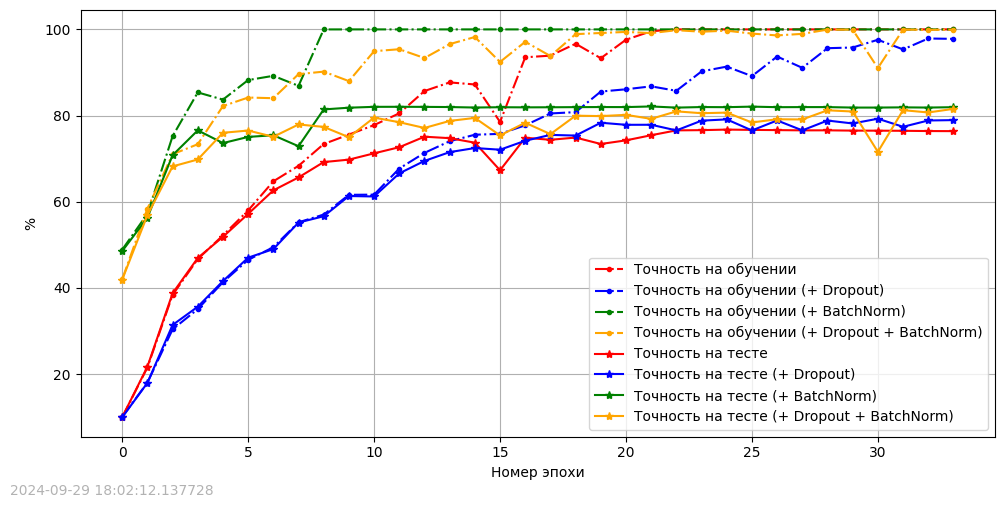

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(train_accs1, label="Точность на обучении", color='red', marker='.', linestyle='-.')
ax.plot(train_accs_dp1, label="Точность на обучении (+ Dropout)", color='blue', marker='.', linestyle='-.')
ax.plot(train_accs_bn1, label="Точность на обучении (+ BatchNorm)", color='green', marker='.', linestyle='-.')
ax.plot(train_accs_bn_dp1, label="Точность на обучении (+ Dropout + BatchNorm)", color='orange', marker='.', linestyle='-.')

ax.plot(test_accs1, label="Точность на тесте", color='red', marker='*')
ax.plot(test_accs_dp1, label="Точность на тесте (+ Dropout)", color='blue', marker='*')
ax.plot(test_accs_bn1, label="Точность на тесте (+ BatchNorm)", color='green', marker='*')
ax.plot(test_accs_bn_dp1, label="Точность на тесте (+ Dropout + BatchNorm)", color='orange', marker='*')

ax.set_xlabel("Номер эпохи")
ax.set_ylabel("$\%$")

ax.grid(True)
ax.legend()

fig.text(
    0.0, 0.0, str(datetime.now()),
    fontsize=10, color='gray', alpha=0.6,
)

fig.tight_layout()
plt.show()

Дайте развёрнутые ответы на вопросы (в этой же ячейке):
1. Какая сеть показала себя лучше всего?
2. Как батчнорм и дропаут влияют на итоговое качество на обучении и на тесте?
3. Как эти модификации влияют на скорость сходимости обучения сети?

__Ответы:__

1. Получилось, что BatchNorm и комбинированная показали лучшее качество на тестовой выборке. Однако BatchNorm гораздо раньше обучилась до 100% на тренировочной выборке (и до примерно 82% на тестовой), получается, она лучше.
2.

Дропаут отключает случайно часть нейронов, поэому нейроны не могут стать зависимы друг от друга, что позволяет избежать переобучения модели. Это видно, так как хоть модель довольно быстро обучилась до 100%, но она не переобучилась при дальнейшем обучении, так как на тренирвочной выборке качество осталось 100%, а на тестовой стабильно 82%, не хуже. (при переобучении мы бы увидели на тестовой выборке падение качества).


Батчнорм делает модель более устойчивой: мы видим, что качество модели на тестовой выборке не колеблется, а остается постоянно примерно 82%. Батчнорм выполняет нормализацию выходов и функций активации. Батчнорм делает обучение стабильным. (и мы видим это на графике: стабильность и лучшее качество)
3.


Батчнорм быстро сходится к локальному минимуму. Также она сглаживает  функцию потерь, что пделается процесс сходимости более стабильным. Это приводит к тому, что значение функции потерь быстрее стремится к нулю на начальных этапах обучения, далее задача не допустить переобучения.

Дропаут уменьшает объем данных, с которыми работает модель, что делает процесс обучения гораздо более быстрым и эффективным, а также с каждым уменьшением объема данных скорость обучения и повышения каечтсва заметно увеличивается (и мы опять это видим - скачкообразное увеличение скорости сходимости)

После того, как модель обучена, обычно её веса необходимо сохранить. В **Pytorch** предусмотрен отдельный интерфейс для сохранения и последующей загрузки весов модели. Во-первых, информацию, необходимую для восстановления состояния модели, можно получить через метод `state_dict` класса `torch.nn.Module`. По умолчанию этот метод возвращает словарь со всеми **ненулевыми параметрами и буферами модели**. Обратный метод `load_state_dict` позволяет установить значения параметров и буферов из словаря. Во-вторых, для сохранения весов на диск и последующей их загрузки с диска используют методы `torch.save` и `torch.load`.

Рассмотрим эту процедуру на примере:

In [35]:
state_dict = conv_network.state_dict()
print(state_dict)

OrderedDict([('features.0.weight', tensor([[[[-4.5985e-02, -1.1124e-01,  9.0189e-02],
          [-8.5428e-02,  9.7292e-02, -1.6670e-01],
          [ 1.2151e-01,  2.7213e-02, -6.1436e-02]],

         [[-1.3706e-01,  1.7461e-01,  3.5253e-02],
          [-6.8703e-02,  7.3979e-02, -8.9501e-02],
          [-1.6167e-01, -5.2124e-02, -1.7167e-01]],

         [[-1.6211e-01,  1.0225e-01,  8.1581e-02],
          [-9.8181e-02, -1.3388e-02, -8.9251e-02],
          [-1.1119e-01,  1.6071e-01, -9.0015e-02]]],


        [[[-1.2009e-01,  6.1628e-02, -1.1170e-01],
          [ 1.5880e-01, -1.5719e-01, -4.1015e-02],
          [-5.3853e-03, -8.6140e-02,  9.5864e-02]],

         [[ 1.5214e-01,  1.2242e-01,  1.9042e-01],
          [ 1.5030e-02,  1.7248e-01, -1.8110e-01],
          [-1.5602e-01, -1.6054e-01,  1.6558e-01]],

         [[ 5.0320e-02,  1.5572e-01,  1.7695e-01],
          [-1.5699e-02, -7.8930e-02,  1.1315e-02],
          [ 9.9086e-02,  2.3580e-03,  5.1852e-02]]],


        [[[ 1.8955e-01, -5.9954

In [36]:
torch.save(state_dict, 'conv_weights.pt')

In [37]:
import os
os.listdir()

['.config',
 'cifar-10-python.tar.gz',
 'conv_weights.pt',
 'cifar-10-batches-py',
 'sample_data']

Заметим, что при работе в **Google Colab**, сохранённые файлы будут существовать лишь пока работает соответствующий Jupyter Notebook. При его перезагрузке, эти данные будут отчищены. Чтобы решить данную проблему, можно выполнить сохранение весов на Ваш личный **Google Drive**, предварительно примонтировав его следующей командой:

```python
from google.colab import drive
drive.mount('/content/drive')
```

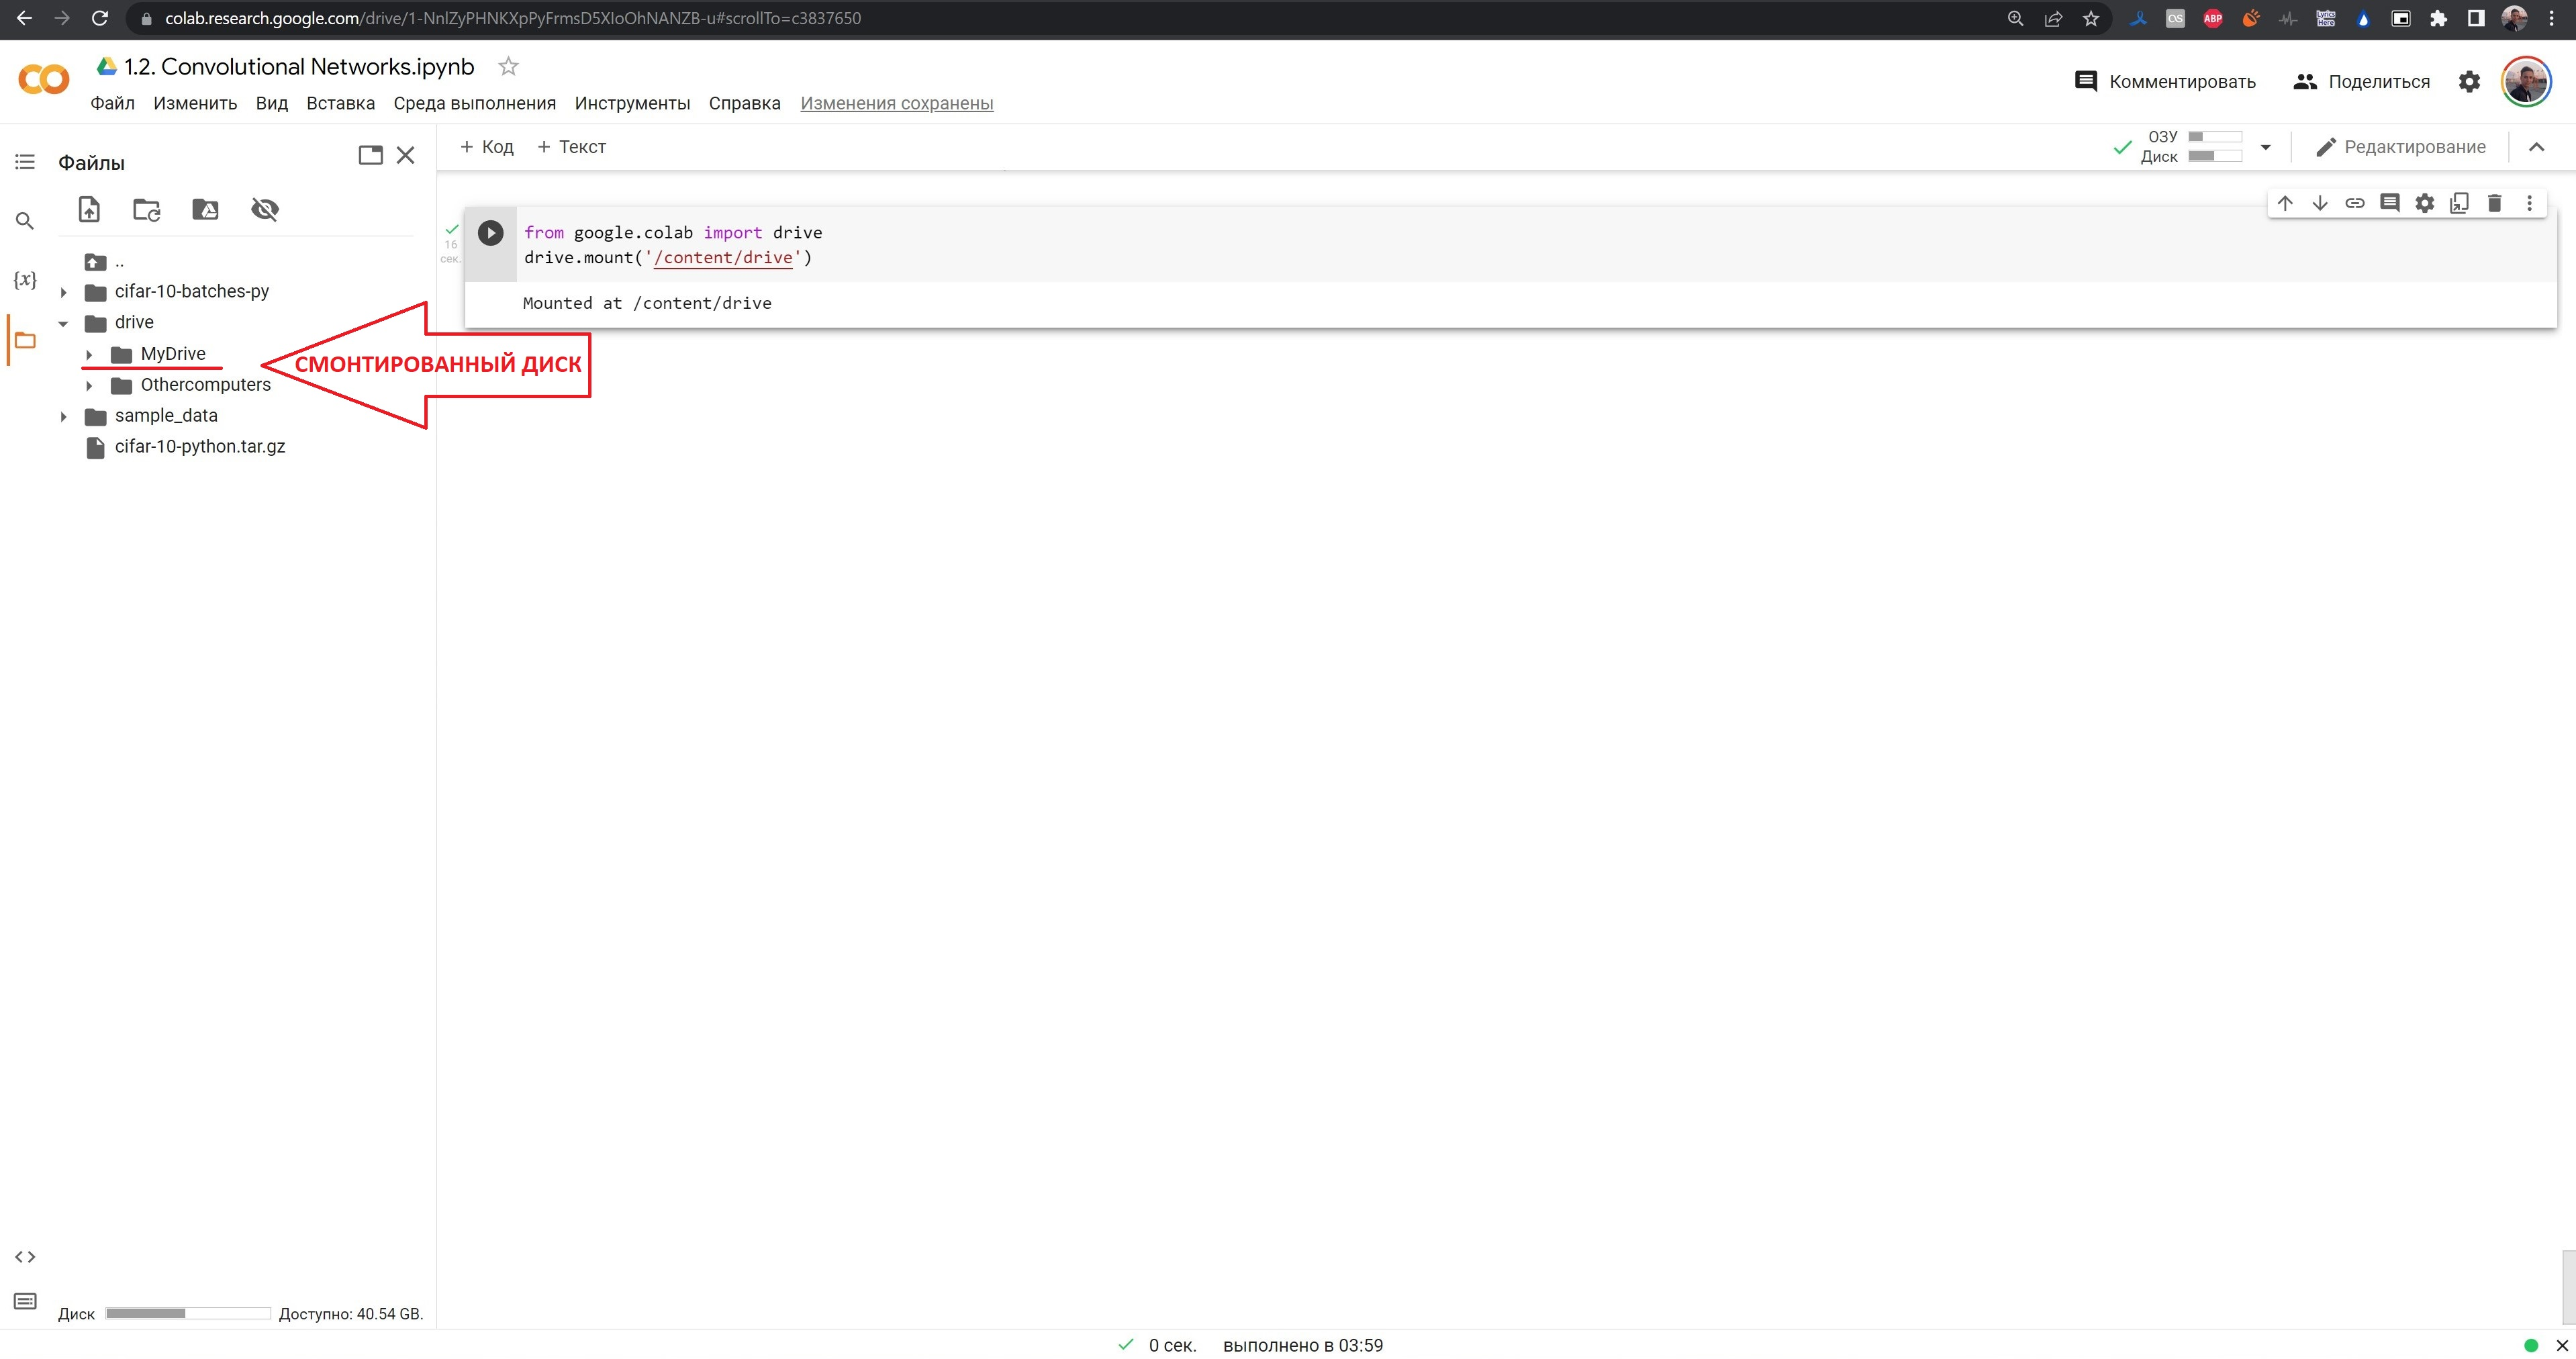

Теперь загрузим веса в "чистую" модель:

<ipython-input-38-bc0b0bd16fe4>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('conv_weights.pt')


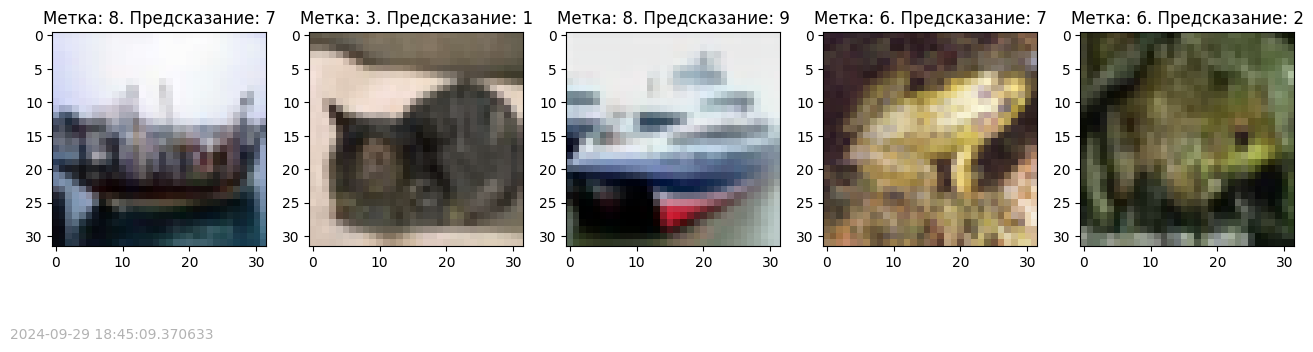

In [38]:
state_dict = torch.load('conv_weights.pt')

conv_network = ConvNet(use_batchnorm=True, dropout_p=0.5)
conv_network.load_state_dict(state_dict)

images, labels = next(iter(dl_test))

logits = conv_network(images)
predictions = torch.argmax(logits, dim=1)

fig, axes = plt.subplots(1, 5, figsize=(13, 4))
for idx, jdx in enumerate(np.random.randint(0, len(images), size=5)):
    axes[idx].imshow(inverse_transform(images[jdx]))
    axes[idx].set_title(f'Метка: {labels[jdx]}. Предсказание: {predictions[jdx]}')

fig.text(
    0.0, 0.0, str(datetime.now()),
    fontsize=10, color='gray', alpha=0.6,
)

fig.tight_layout()
plt.show()

Обратите внимание, что загрузка весов модели с помощью `torch.load` (а также с помощью любых других производных от [`pickle`](https://docs.python.org/3/library/pickle.html) функций) является [**небезопасной операцией**](https://pytorch.org/docs/stable/generated/torch.load.html#torch.load). В процессе загрузки потенциально может выполняться абсолютно любой Python код. Поэтому используйте только те предобученные модели, которым Вы доверяете.

Для примера, попробуйте загрузить веса, модифицированные особым образом:

In [40]:
torch.load('conv_weights_pretrained.pt')

<ipython-input-40-3a6ed718ebb8>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load('conv_weights_pretrained.pt')


<IPython.core.display.Javascript object>

{'features.0.weight': tensor([[[[ 0.0135, -0.1222, -0.0140],
           [-0.0583, -0.0326, -0.0327],
           [ 0.0364, -0.0228, -0.0144]],
 
          [[-0.1221,  0.0279, -0.0010],
           [ 0.1580,  0.0674, -0.1431],
           [-0.0802,  0.1627,  0.1680]],
 
          [[ 0.0060, -0.1505, -0.1332],
           [-0.1881,  0.0770,  0.1451],
           [ 0.1693,  0.1653, -0.0989]]],
 
 
         [[[-0.1572,  0.0840,  0.1532],
           [-0.1795,  0.1075,  0.0705],
           [ 0.0207, -0.1909,  0.0500]],
 
          [[-0.0900,  0.1825,  0.1370],
           [-0.0408, -0.1705, -0.0184],
           [ 0.1715,  0.0555, -0.0777]],
 
          [[-0.0672,  0.1577,  0.0703],
           [ 0.1888,  0.0674,  0.0603],
           [-0.1027, -0.1378,  0.0135]]],
 
 
         [[[-0.0790, -0.0692, -0.1516],
           [-0.1701,  0.1475,  0.0321],
           [-0.0049,  0.1399,  0.1633]],
 
          [[ 0.0734,  0.0740,  0.1897],
           [ 0.0612, -0.0136, -0.1917],
           [-0.0429,  0.0188, -0